# 演習問題2-10

## 2.3 データを入手する

### 2.3.2 データをダウンロードする

In [1]:
# データをロードする
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

### 2.3.3 データの構造をざっと見る

In [2]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


* `total_bedrooms` には null 値が含まれていることがわかる．
* `ocean_proximity` のDtypeが `object` になっているが，CSVから読み込んでいるので実際には string

In [3]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

実際に `ocean_proximity` の値は inland, near ocean, near bay, island の４通りであることがわかる

In [4]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


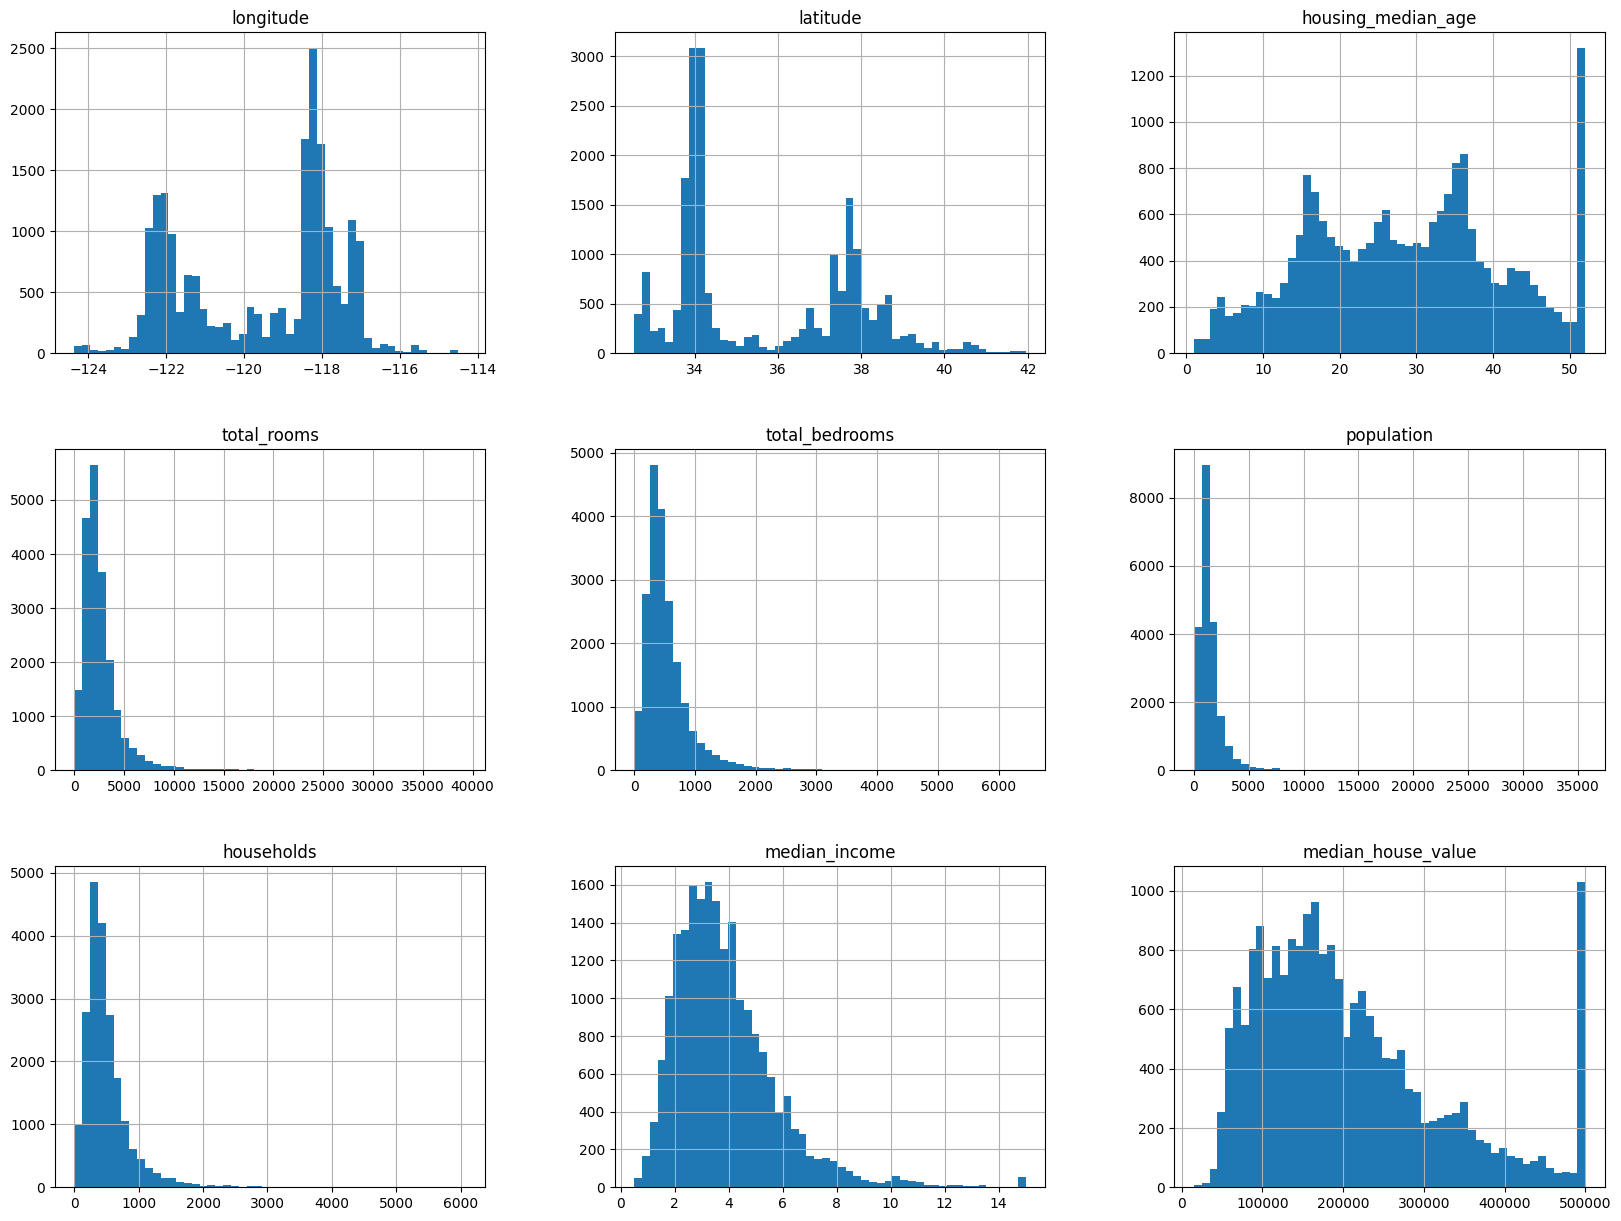

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
# bins はヒストグラムに表示されるバーの数
housing.hist(bins=50, figsize=(20, 15))
plt.show()

#### ヒストグラムから分かること

* 各数値属性の単位は何か？
  * 収入の中央値 `median_income` の単位が１ドルではないように見える．
  * 数値は１万ドル単位になっている

* 上限を切ってあるデータがある
* データの分布が正規分布ではなくて，tail heavy になっているのがわかる．後で変換しなくてはいけない.

### 2.3.4 テストセットを作る

#### 無作為にサンプリングしてテストデータを作る

In [6]:
import numpy as np

np.random.seed(42)

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)

#### 収入の中央値に関して，層化抽出を行う

収入カテゴリという属性を新たに作る

<Axes: >

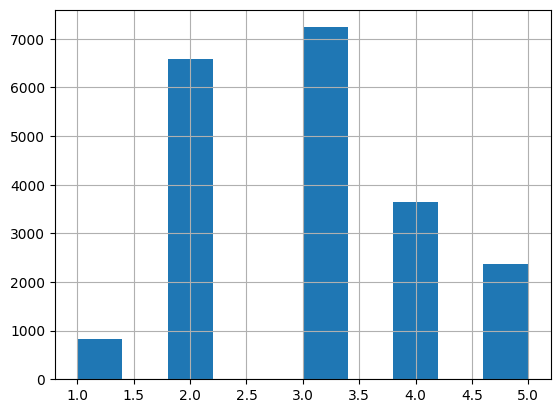

In [7]:
housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)
housing["income_cat"].hist()

In [8]:
# 層化抽出(Stratified) を実際に行う
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [9]:
# income_cat 属性を取り除く
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## 2.4 データを研究・可視化して理解を深める

In [10]:
# 訓練セットのコピーを作る
housing: pd.DataFrame = strat_train_set.copy()

### 2.4.1 地理データの可視化

緯度と経度はそのままでは理解しづらいので，散布図を作る

<Axes: xlabel='longitude', ylabel='latitude'>

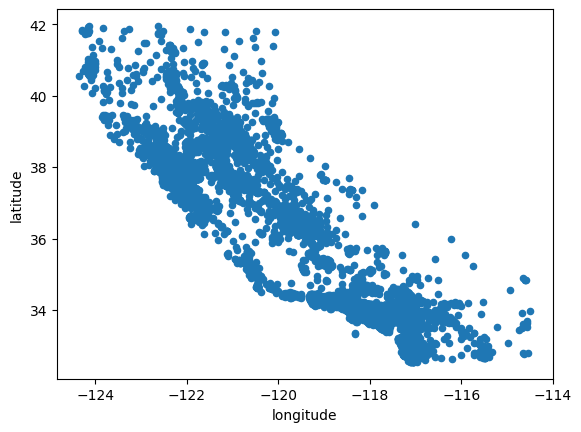

In [11]:
housing.plot(kind="scatter", x="longitude", y="latitude")

データが重なり過ぎていて見づらいので，重なりも含めて可視化する

<Axes: xlabel='longitude', ylabel='latitude'>

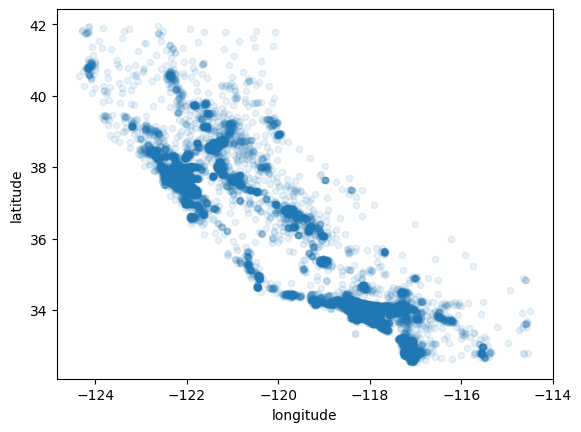

In [12]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

人口と住宅価格を加味してみる

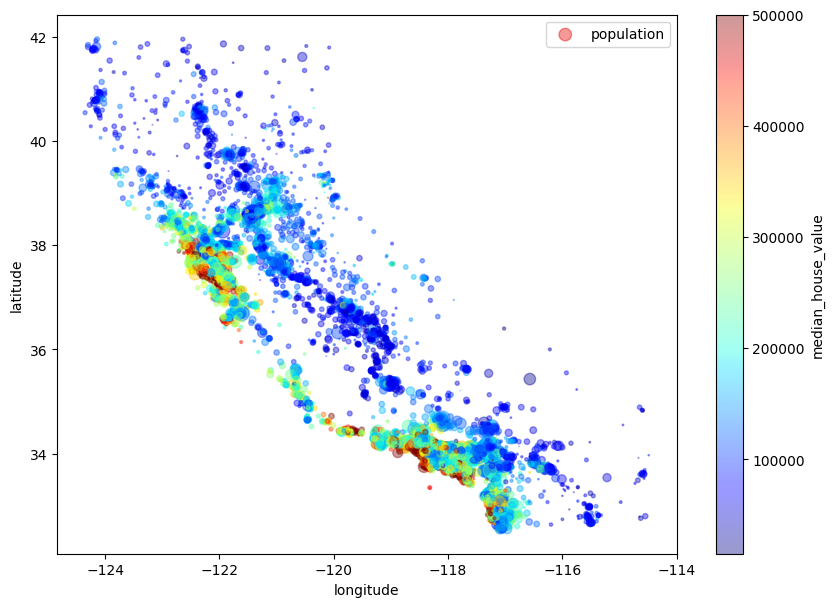

In [13]:
housing.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    alpha=0.4,
    # 円の大きさが人口を表す
    s=housing["population"]/100,
    label="population",
    figsize=(10, 7),
    # 色が住宅価格を表す
    c="median_house_value",
    cmap=plt.get_cmap("jet"),
    colorbar=True,
)
plt.legend()

### 2.4.2 相関を探す

In [14]:
# データのすべての属性のペアに対して，相関係数を計算する
corr_matrix = housing.corr()

C:\Users\11325\AppData\Local\Temp\ipykernel_7500\2663571635.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


In [15]:
# 個々の属性と住宅価格の中央値の間にどれだけの相関があるかを見る
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

相関が強いものは収入の中央値くらいで，後のものの相関は絶対値がすべて 0.2 以下で，相関が弱いことがわかる

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

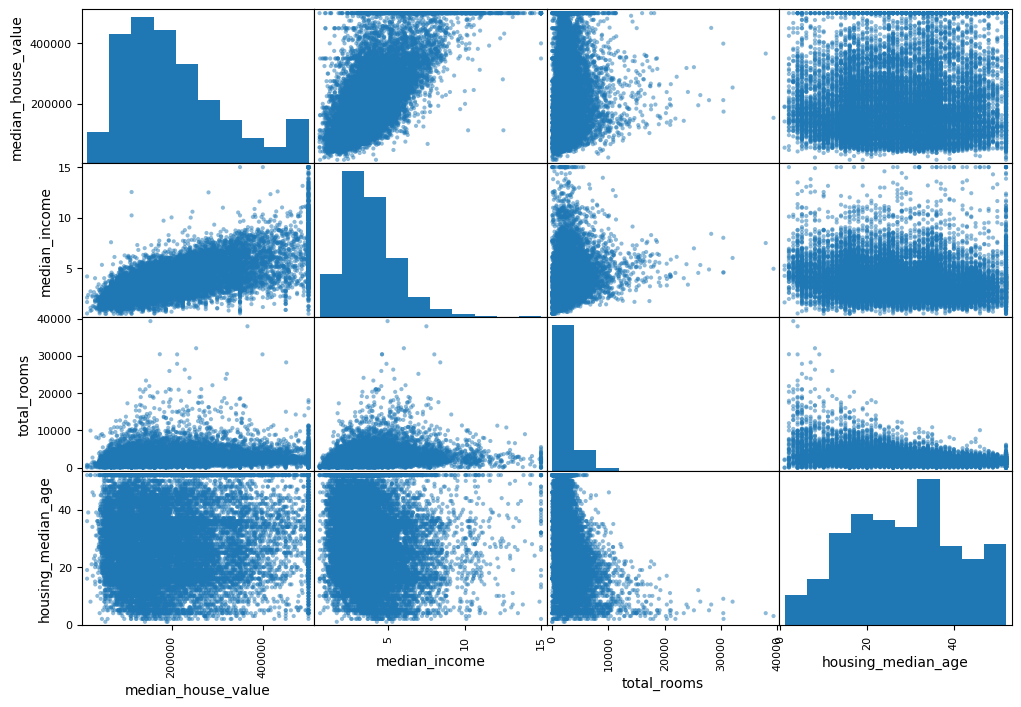

In [16]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

<Axes: xlabel='median_income', ylabel='median_house_value'>

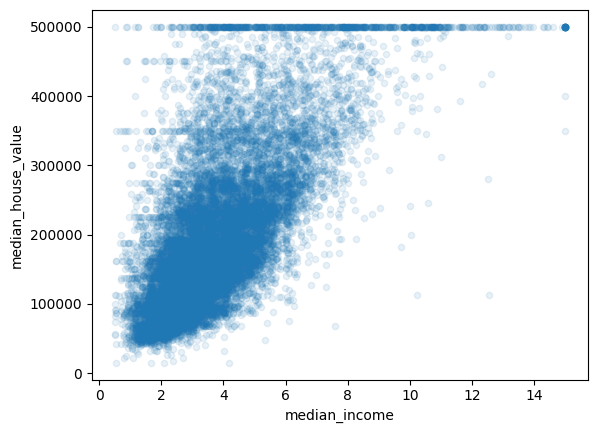

In [17]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

この図から，50万ドル付近，45万ドル付近，35万ドル付近に横線があることがわかる．

対応する区域を訓練セットから取り除いた方がいいかも

### 2.4.3 属性の組み合わせを試してみる

In [18]:
# 世帯当たりの部屋数
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]

# 寝室の占める割合
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]

# 世帯あたりの人数
housing["population_per_household"] = housing["population"] / housing["households"]

In [19]:
corr_matrix = housing.corr()

C:\Users\11325\AppData\Local\Temp\ipykernel_7500\2466220658.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


In [20]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688380
rooms_per_household         0.143663
total_rooms                 0.137455
housing_median_age          0.102175
households                  0.071426
total_bedrooms              0.054635
population                 -0.020153
population_per_household   -0.038224
longitude                  -0.050859
latitude                   -0.139584
bedrooms_per_room          -0.256397
Name: median_house_value, dtype: float64

## 2.5 機械学習アルゴリズムが処理しやすいようにデータを準備する

In [21]:
# データとラベルを分離する
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### 2.5.1 データをクリーニングする

`total_bedrooms` 属性に欠損値があるので，それに対処する

In [22]:
from sklearn.impute import SimpleImputer

# 欠損値を中央値で置き換える
imputer = SimpleImputer(strategy="median")

# 数値属性だけに絞る
housing_num = housing.drop("ocean_proximity", axis=1)

imputer.fit(housing_num)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [23]:
# imputer を使って，欠損値を学習した中央値に置き換える
X = imputer.transform(housing_num)

# dataFrame にする
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [24]:
# 欠損値がなくなっていることを確認する
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 13096 to 19888
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


### 2.5.2 テキスト/カテゴリ属性の処理

In [25]:
# テキストラベルを数値に変換する
housing_cat = housing[["ocean_proximity"]]

from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

housing_cat_encoded[:10]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.],
       [0.]])

In [26]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [27]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### 2.5.3 カスタム変換器

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        """何もしない"""
        return self

    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]

        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[
                X,
                rooms_per_household,
                population_per_household,
                bedrooms_per_room
            ]
        else:
            return np.c_[
                X,
                rooms_per_household,
                population_per_household,
            ]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### 2.5.5 変換パイプライン

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [30]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

## 2.6 モデルを選択して訓練する

### 2.6.1 訓練セットを訓練，評価する

In [31]:
# 線形回帰モデルを訓練する
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
print("done!")

done!


In [32]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

67769.12117461127

In [33]:
# 決定木モデルを訓練する
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [34]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### 2.6.2 交差検証を使ったよりよい評価

In [35]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    tree_reg,
    housing_prepared,
    housing_labels,
    scoring="neg_mean_squared_error",
    cv=10
)
tree_rmse_scores = np.sqrt(-scores)

In [36]:
tree_rmse_scores.mean()

69986.66503930914

In [37]:
lin_scores = cross_val_score(
    lin_reg,
    housing_prepared,
    housing_labels,
    scoring="neg_mean_squared_error",
    cv=10
)
lin_rmse_scores = np.sqrt(-lin_scores)
lin_rmse_scores.mean()

67959.04949031149

In [38]:
# ランダムフォレストモデルを訓練する
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

# 訓練セットで評価する
housing_predictions = forest_reg.predict(housing_prepared)
forst_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forst_mse)
print(f"訓練セットでの成績は{forest_rmse}")


訓練セットでの成績は18440.608047529513


In [45]:
forst_scores = cross_val_score(
    forest_reg,
    housing_prepared,
    housing_labels,
    scoring="neg_mean_squared_error",
    cv=10
)
lin_rmse_scores = np.sqrt(-forst_scores)
lin_rmse_scores.mean()

49759.85464486444

ランダムフォレストモデルは性能が良いが，訓練セットよりも検証セットでの値がひどく悪く，過学習しているきらいがある．

In [46]:
import joblib

joblib.dump(forest_reg, "forest_model.pkl")

['forest_model.pkl']

### 演習問題2.10-(1)
SVM 回帰を試してみよう．`kernel="linear` や `rbf` としてハイパーパラメータを試してほしい
性能はどれくらいか？

In [60]:
from sklearn.svm import SVR

# SVM回帰を訓練する
# kernel を線形にする
svm_reg = SVR(kernel="linear", C=19)
svm_reg.fit(housing_prepared, housing_labels)

# SVM回帰を訓練セットで評価する
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

76499.91426647884

結果：
|C  | rmse    |
|---|---------|
|1  | > 100000|
|3  |98991    |
|5  |91309    |
|7  |86173    |
|9  | 82822   |
|11 | 80904   |
|13 | 79526   |
|15 | 78260   |
|17 | 77296   |
|19 | 76499   |

In [63]:
# ベストな値を探す

minimum = 76499.9

for c in range(20, 100):
    # SVM回帰を訓練する
    # kernel を線形にする
    svm_reg = SVR(kernel="linear", C=c * 10)
    svm_reg.fit(housing_prepared, housing_labels)

    # SVM回帰を訓練セットで評価する
    housing_predictions = svm_reg.predict(housing_prepared)
    svm_mse = mean_squared_error(housing_labels, housing_predictions)
    svm_rmse = np.sqrt(svm_mse)
    if svm_rmse < minimum:
        print(minimum)
        print(c * 10)
        minimum = svm_rmse
    else:
        print("terminate!")
        print(minimum)
        print(c * 10)
        break

76499.9
200
71742.14835111766
210
terminate!
71692.71903149792
220


In [66]:
# ベストな値を探す

minimum = 76499.9

for c in range(1, 100):
    # SVM回帰を訓練する
    # kernel をrbfにする
    svm_reg = SVR(kernel="rbf", C=c)
    svm_reg.fit(housing_prepared, housing_labels)

    # SVM回帰を訓練セットで評価する
    housing_predictions = svm_reg.predict(housing_prepared)
    svm_mse = mean_squared_error(housing_labels, housing_predictions)
    svm_rmse = np.sqrt(svm_mse)
    if svm_rmse < minimum:
        print(minimum)
        print(c)
        minimum = svm_rmse
    else:
        print("terminate!")
        print(minimum)
        print(c)
        break

terminate!
76499.9
1


## 2.7 モデルを微調整する

### 2.7.1 グリッドサーチ

In [39]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"n_estimators": [3, 10, 10], "max_features": [2, 4, 6, 8]},
    {"bootstrap": [False], "n_estimators": [3, 10], "max_features": [2, 3, 4]},
]

forest_reg= RandomForestRegressor()
grid_search = GridSearchCV(
    forest_reg,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

grid_search.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 10]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [40]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 4, 'n_estimators': 10}

In [41]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=4, n_estimators=10)

In [42]:
cvres = grid_search.cv_results_
cvres

{'mean_fit_time': array([0.10379887, 0.3442718 , 0.33811245, 0.16250138, 0.55012727,
        0.54891272, 0.22698331, 0.76765246, 0.76120825, 0.29392085,
        0.98211336, 0.98105998, 0.10273585, 0.33844233, 0.1296061 ,
        0.43546247, 0.16148705, 0.53129678]),
 'std_fit_time': array([0.00349143, 0.00802724, 0.00542194, 0.00175775, 0.00484971,
        0.00417074, 0.00242532, 0.01366083, 0.00519951, 0.00463775,
        0.00990213, 0.01503637, 0.00190428, 0.00213186, 0.00200267,
        0.00729706, 0.00229509, 0.00851722]),
 'mean_score_time': array([0.00362201, 0.00977502, 0.0096683 , 0.00343823, 0.0090992 ,
        0.00936809, 0.00280066, 0.00899992, 0.00941601, 0.00320153,
        0.00913291, 0.00931706, 0.00380816, 0.01051073, 0.00319138,
        0.01040049, 0.004004  , 0.01069813]),
 'std_score_time': array([5.07313939e-04, 6.57068050e-04, 9.93298103e-04, 4.38402123e-04,
        5.61478303e-04, 3.97710822e-04, 4.00877637e-04, 1.87488587e-06,
        5.17313040e-04, 4.02307864e-

### 2.7.4 最良のモデルと誤差の分析

In [43]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([8.52988687e-02, 8.36319183e-02, 4.70890366e-02, 2.32887482e-02,
       1.92511975e-02, 2.05989817e-02, 1.89885442e-02, 3.05530680e-01,
       6.21980957e-02, 1.04742640e-01, 8.97527616e-02, 9.95130957e-03,
       1.14056641e-01, 9.22565501e-05, 7.21387582e-03, 8.31444479e-03])

In [44]:
extra_attribs = ["room_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3055306796240025, 'median_income'),
 (0.11405664145247914, 'INLAND'),
 (0.10474263982325033, 'pop_per_hhold'),
 (0.08975276159212019, 'bedrooms_per_room'),
 (0.08529886867103241, 'longitude'),
 (0.0836319182684399, 'latitude'),
 (0.06219809571181272, 'room_per_hhold'),
 (0.04708903655709161, 'housing_median_age'),
 (0.023288748179141224, 'total_rooms'),
 (0.02059898173322273, 'population'),
 (0.019251197475393802, 'total_bedrooms'),
 (0.01898854418848074, 'households'),
 (0.009951309565284243, '<1H OCEAN'),
 (0.00831444478914956, 'NEAR OCEAN'),
 (0.007213875819002848, 'NEAR BAY'),
 (9.22565500961921e-05, 'ISLAND')]